In [2]:
import numpy as np
# from gym.utils import seeding
# from gym.spaces import Discrete, Tuple, Box
# import gym
from qiskit.quantum_info import state_fidelity
from qiskit import *
from numpy.linalg import matrix_power
import pandas as pd
# import cmath

In [3]:
def generate_target_circuit(n):
    s = np.array([1, 0])
    ht = GATES[0] @ GATES[1]
    return matrix_power(ht, n) @ s

def statevector_to_angles(state):
    svp = [abs(state[0])*np.exp(1j * np.angle(state[0])), abs(state[1])*np.exp(1j * np.angle(state[1]))]
    svp /= np.exp(1j * np.angle(state[0]))
    theta = 2 * np.arccos(abs(svp[0]))
    phi = np.angle(svp[1])
    if (phi < 0): phi += 2*np.pi
    return theta, phi
    # return np.cos(theta / 2) * np.array([1,0]) + np.exp(1j * phi) * np.sin(theta / 2) * np.array([0, 1])

def statevector_to_bloch_reg(state):
    theta, phi = statevector_to_angles(state)

    # take into consideration the poles
    for i in range(len(thetas)):
        if (theta in thetas[i]):
            theta_reg = i
    for i in range(len(phis)):
        if (phi in phis[i]):
            phi_reg = i

    if (theta_reg == 0):
        theta_reg = phi_reg = 0
    if (theta_reg == len(thetas)-1):
        theta_reg = len(thetas)-1
        phi_reg = len(phis)-1
    return (theta_reg, phi_reg)

def random_state_in_reg(reg):
    if (reg[0] == 0 or reg[0] == len(thetas)-1):
        phi = np.random.uniform(0, 2*np.pi)
    else:
        phi = np.random.uniform(phis[reg[1]].left, phis[reg[1]].right)
    theta = np.random.uniform(thetas[reg[0]].left, thetas[reg[0]].right)
    return np.cos(theta / 2) * np.array([1,0]) + np.exp(1j * phi) * np.sin(theta / 2) * np.array([0, 1])

def statevector_to_bloch_point(state):
    svp = [abs(state[0])*np.exp(1j * np.angle(state[0])), abs(state[1])*np.exp(1j * np.angle(state[1]))]
    svp /= np.exp(1j * np.angle(svp[0]))
    theta = 2 * np.arccos(abs(svp[0]))
    phi = np.angle(svp[1])
    return np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)

def random_unitary(dim):
  # follows the algorithm in https://arxiv.org/pdf/math-ph/0609050.pdf
  Z = np.array([np.random.normal(0, 1) + np.random.normal(0, 1) * 1j for _ in range(dim ** 2)]).reshape(dim, dim)
  Q, R = np.linalg.qr(Z)
  diag = np.diagonal(R)
  lamb = np.diag(diag) / np.absolute(diag)
  unitary = np.matmul(Q, lamb)
  assert np.allclose(unitary.conj().T @ unitary, np.eye(dim))
  return unitary

In [4]:
n = 10**6
k = 10

GATES = {
    0: np.array([[1, 1], [1, -1]]) * 1/np.sqrt(2), # H
    1: np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]]), # T
    # 2: np.array([[0, 1], [1, 0]]), # X
    2: np.array([[1, 0], [0, 1]]) # I
}

goal = generate_target_circuit(n=n)
# goal = random_unitary(2)
thetas = np.array(pd.cut(np.linspace(0, np.pi, k), k, precision=10, include_lowest=True))
thetas[0] = pd.Interval(0, thetas[0].right, closed='both')
phis = np.array(pd.cut(np.linspace(0, 2*np.pi, 2*k), 2*k,  precision=10, include_lowest=True))
phis[0] = pd.Interval(0, phis[0].right, closed='both')
goal_reg = statevector_to_bloch_reg(goal)

states = [(i, j) for i in range(len(thetas)) for j in range(len(phis))]
values = np.zeros(len(thetas) * len(phis))

In [5]:
target_state = generate_target_circuit(40)
target_state_angles = statevector_to_angles(target_state)
print(target_state_angles)
print(statevector_to_bloch_reg(target_state))
statevector_to_angles(random_state_in_reg((1, 5)))


(1.6485615476912479, 5.838924942703547)
(5, 18)


(0.5056804528022281, 1.706961420813825)

In [6]:
states

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (4, 18),
 (4, 19),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 

In [7]:
transitions = [np.zeros((len(states), len(states)), dtype=np.float16) for i in range(len(GATES))]

# building transition matrices
for s in states:
    
    #Generate 100 test values to get a distrubtion
    for i in range(100):    
        #Generate random state within the bloch region
        state = random_state_in_reg(s)
        
        for j in range(len(GATES)):
            
            #Apply the gate to said state and obtain its new region
            new_state = statevector_to_bloch_reg(GATES[j] @ state)

            #Find the index of the new state
            new_state_ind = states.index(new_state)

            #Reason for this is to merge all states that converge to the pole
            state_ind = states.index(statevector_to_bloch_reg(state))

            #Add one to notify that starting in a state has the probablity to land in another
            transitions[j][state_ind][new_state_ind] += 1

#This converts values into probablity instead of number of times. Therefor, transitions now acts as a probablity distrabution       
for i in range(len(GATES)):
    for j in range(len(states)):
        transitions[i][j] = np.nan_to_num(transitions[i][j] / sum(transitions[i][j]))

C:\Users\dbran\AppData\Local\Temp\ipykernel_196\66510098.py:28: RuntimeWarning: invalid value encountered in true_divide
  transitions[i][j] = np.nan_to_num(transitions[i][j] / sum(transitions[i][j]))


In [8]:
np.set_printoptions(precision=8)
print(np.nonzero(transitions[0][0]))
print(transitions[0][0][100])


(array([ 80,  99, 100, 119], dtype=int64),)
0.246


In [9]:
#This defines the reward function. Reward to network iff it is in the goal bloch region
def R(state, action):
    if (state == goal_reg):
        return 1
        # if (action <= len(GATES) - 2):
        #     return 0
        # else:
        #     return 0.1 # to encourage using identity
    else:
        return 0

In [76]:
#This function will be cruical in the policy update. Returns np.array that is the expected values of each state 
def policy_eval(policy, discount_factor=0.8, epsilon=0.000001):
    #Create an array of zeros the length of now many states/bloch regions we have
    V_old = np.zeros(len(states))

    #Breaks iff delta < epsilon where delta is the max expected return
    while True:
    # for i in range(1):
        V_new = np.zeros(len(states))
        delta = 0
        for s in range(len(states)):
            v_fn = 0
            #The probablity of taking a certain action based on a state
            action_probs = policy[s]
            for a in range(len(GATES)):
                #proababilty of the future states
                p_trans = transitions[a][s]
                #Find the indexs of all states in which the probility is not zero
                p_next_states = np.nonzero(transitions[a][s])[0]
                #Find the value of the current state. Sum over all future states and all rewards(there is only one per state)
                #i.e. Expecture Reward of state s
                for next_s in p_next_states:
                    #Page 55 G_t = R_t+1 + yG_t+1                  R_t+1            discountfactor      G_t+1
                    #Value function of the policy Page 59
                    v_fn += action_probs[a] * p_trans[next_s] * (R(states[s], a) + discount_factor * V_old[next_s])
            #If the current delta is less than the increase in value set delta =
            delta = max(delta, abs(v_fn - V_old[s]))
            #Set value of the current = to our expected reward
            V_new[s] = v_fn
        #Set the expected values of S_t-1 to be used again
        V_old = V_new

        #If we have gone too deep/estimated too many steps in the future, break out of the loop
        if(delta < epsilon):
            break
    
    # since technically the entire north/south pole is one state, copy (0, 0) and (k-1, k-1) over
    # won't ever be used, but it is needed for the visualization
    for i in range(1, len(phis)):
        V_old[i] = V_old[0]
        V_old[len(thetas)*len(phis)-1-i] = V_old[len(thetas)*len(phis)-1]
    return np.array(V_old)


In [86]:
policy = np.ones([len(states), len(GATES)]) / len(GATES)
print(states.index(goal_reg))
print(np.argmax(policy_eval(policy)))


(5, 17)
117


In [78]:
#Returns a policy and a value function
def policy_improvement(policy_eval_fn=policy_eval, discount_factor=0.8):     

    #Given a state and value of said state, find the expected value of that state
    def one_step_lookahead(s, V_old):
        #Create an empty list where the values of the actions will be stores or q_pi(s,a)
        actions = np.zeros(len(GATES))
        #For each action, compute q_pi(s,a)
        for a in range(len(GATES)):
            #Set the current value = 0
            v_fn = 0
            #Get probablity of all future steps
            p_trans = transitions[a][s]
            #Get the indexs of all future states with a probablity that isn't zero
            p_next_states = np.nonzero(transitions[a][s])[0]
            #Loop through those states
            for next_s in p_next_states:
                #(3.9) Find the current G_t+1 
                v_fn += p_trans[next_s] * (R(states[s], a) + discount_factor * V_old[next_s])
            #Set the value of that action in the actions array
            actions[a] = v_fn
        #Return the computed/expected value of an action
        return actions
    #End of function definition
    #A policy is mapping the states to a probablistic action
    policy = np.ones([len(states), len(GATES)]) / len(GATES)

    #Define actions, I.e. the gates so we can calcuate the expected value of each action
    actions_values = np.zeros(len(GATES))
    
    while True:
        #Getting an array that is the expected values of a state given our policy
        value_fn = policy_eval_fn(policy)
        policy_stable = True
        for s in range(len(states)):
            actions_values = one_step_lookahead(s, value_fn)
            best_action = np.argmax(actions_values)
            chosen_action = np.argmax(policy[s])
            if(best_action != chosen_action):
                policy_stable = False
            policy[s] = np.eye(len(GATES))[best_action]
        
        if(policy_stable):
            return policy, value_fn

In [79]:
n = 10**6
goal = generate_target_circuit(n=n)
goal_reg = statevector_to_bloch_reg(goal)

#Generate and train policy
policy, v = policy_improvement(policy_eval)

In [ ]:
np.count_nonzero(v)

200

In [80]:
optimal_programs = []
for i in range(k):
    converged = False
    while not converged:
        s = random_state_in_reg((0, 0))
        prog = []
        counter = 0
        while counter < 30:
            action = np.argmax(policy[states.index(statevector_to_bloch_reg(s))])
            next_s = GATES[action] @ s
            prog.append(action)
            # next_s = random_state_in_reg(statevector_to_bloch_reg(next_s))
            s = next_s
            counter += 1
            if (statevector_to_bloch_reg(s) == goal_reg):
                print('converged')
                converged = True
                break
        
    optimal_programs.append(prog)
optimal_programs

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


[[0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 0, 1]]

In [81]:
prog = optimal_programs[np.argmin(np.array([len(i) for i in optimal_programs]))]
fidelities = []
numTrials = 100
print(prog)
# prog = [0, 1, 1, 0]
for i in range(100000):
    s = np.array([1, 0])
    s = random_state_in_reg((0,0))
    for a in prog:
        s = GATES[a] @ s
    f = state_fidelity(s, goal)
    if (statevector_to_bloch_reg(s) == goal_reg):
        fidelities.append(f)
        break
    # print(goal, s)
print(np.average(fidelities))

[0, 1, 1, 0, 1]
0.9912750248080953


In [ ]:
goals = []

# prog = optimal_programs[np.argmin(optimal_programs)]
# for i in range(k):
#     s = random_state_in_reg((0,0))
#     for a in prog:
#         s = GATES[a] @ s

# goals.append(s)
for i in range(200000):
    num = bin(i)[2:]
    psi = np.array([1,0])
    for j in num:
        psi = GATES[int(j)] @ psi
    # goals.append(generate_target_circuit(i))
    goals.append(psi)
    # goals.append(random_unitary(2) @ np.array([1,0]))
xp = []
yp = []
zp = []
for i in range(len(goals)):
    theta, phi = statevector_to_angles(goals[i])
    xp.append(np.sin(theta)*np.sin(phi))
    yp.append(np.sin(theta)*np.cos(phi))
    zp.append(np.cos(theta))

C:\Users\dbran\AppData\Local\Temp\ipykernel_22004\974390621.py:9: RuntimeWarning: invalid value encountered in arccos
  theta = 2 * np.arccos(abs(svp[0]))


C:\Users\dbran\AppData\Local\Temp\ipykernel_22004\1925367473.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


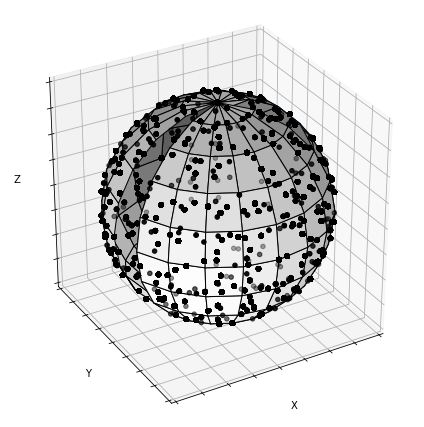

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# xp, yp, zp = np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)
# print(xp, yp, zp)
# draw a vector

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
fig = plt.figure(figsize=plt.figaspect(2)*1.5) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.gca(projection='3d')
plt.tight_layout()
ax.set_box_aspect([1,1,1])

# Make data
r = 1.0

t = [0]
p = [-np.pi]
for i in range(len(thetas)):
    t.append(min(thetas[i].right, np.pi))
for i in range(len(phis)):
    p.append(min(phis[i].right, 2*np.pi))

# t = np.linspace(0, np.pi, k)
# p = np.linspace(-np.pi, np.pi, k)

theta,phi = np.meshgrid(p,t)

x = r*np.cos(theta)*np.sin(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(phi)

norm = plt.Normalize()
# colors = plt.cm.winter(norm(v.reshape(len(thetas), len(phis))))
surf = ax.plot_wireframe(x, y, z, alpha=0.8)
# surf = ax.plot_surface(x, y, z, facecolors=colors, alpha=1)

surf = ax.plot_surface(x, y, z, color='w', alpha=1)

surf.set_edgecolors('k')
ax.scatter(xp, yp, zp, color='k', s=20)
ax.view_init(azim=60, elev=30)
# ax.axis('off')

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()

# ax.set_yticks([])
# ax.set_xticks([])
# ax.set_zticks([])

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])

plt.grid(True)
# plt.savefig('figures/policy.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()
